<a href="https://colab.research.google.com/github/dheerajvarma24/Adversarial_attack_and_training_task/blob/main/Adversarial_attack_and_training_HiWi_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Get the MNIST data
train_mnist = datasets.MNIST("../data", download=True, train=True, transform=transforms.ToTensor())
test_mnist = datasets.MNIST("../data", download=True, train=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_mnist, batch_size=100, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
# Define neural network model to train MNIST dataset
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [4]:
# Define the adversarial attack type that is Projected Gradient Descent (PGD)
# compute the noise (delta) with respect to input's average L_2 & L_infinity norms.

def pgd(model, X, y, epsilon=2.0, alpha=0.1, num_iter=20):
    #initialize with zeros
    delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        #L_inifinity norm
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        #L_2 norm
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # clip X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)

        delta.grad.zero_()
    
    return delta.detach()

def norms(Z):
    # to compute norm
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]

In [5]:
#standard training and evaluation procedure 
def standard_epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset)


In [6]:
# Adversarial training and evaluation procedure 
def adversarial_epoch(loader, model, pgd, opt=None, **kwargs):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = pgd(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset)

In [7]:
# Perform actual training and monitor training, test and adversarial loss.
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err = standard_epoch(train_loader, model_cnn, opt)
    test_err = standard_epoch(test_loader, model_cnn)
    adv_err = adversarial_epoch(test_loader, model_cnn, pgd)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
print("Train error after 10 epochs: %.5f" %train_err)
print("Test error after 10 epochs: %.5f" %test_err)
print("adversarial error after 10 epochs: %.5f" %adv_err)
torch.save(model_cnn.state_dict(), "model_cnn.pt")

0.280983	0.028800	0.446600
0.026683	0.020500	0.432100
0.017200	0.016400	0.443400
0.012883	0.015600	0.490300
0.009550	0.014800	0.503600
0.004183	0.010900	0.449000
0.003083	0.010900	0.467100
0.002450	0.011100	0.453400
0.002133	0.011400	0.475600
0.002017	0.011100	0.479400
Train error after 10 epochs: %.5f 0.0020166666666666666
Test error after 10 epochs: %.5f 0.0111
adversarial error after 10 epochs: %.5f 0.4794


In [8]:
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

In [9]:
# visualize the examples from MNIST dataset
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

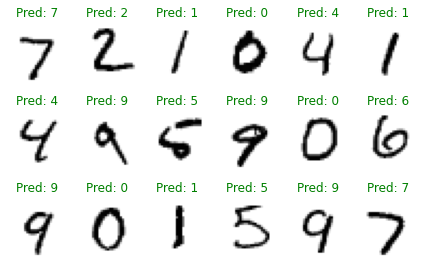

In [10]:
# Visualize test dataset samples accuracy classified by trained cnn model
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

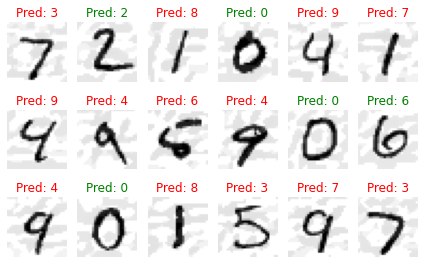

In [11]:
# Visualize test dataset samples accuracy that are perturbed by PGD attack and classified by trained cnn model
delta = pgd(model_cnn, X, y)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [12]:
# Define another neural network model to perform adversarial train MNIST dataset
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [13]:
# Perform adversarial training and monitor training, test and adversarial loss.
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err = adversarial_epoch(train_loader, model_cnn_robust, pgd, opt)
    test_err = standard_epoch(test_loader, model_cnn_robust)
    adv_err = adversarial_epoch(test_loader, model_cnn_robust, pgd)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    if t==0:
      print("train err \t  \t adv err")
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

print("Train error after 10 epochs: %.5f" %train_err)
print("Test error after 10 epochs: %.5f" %test_err)
print("adversarial error after 10 epochs: %.5f" %adv_err)
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

0.397767	0.026800	0.079600
0.072317	0.014300	0.050200
0.049200	0.012000	0.043400
0.040017	0.011800	0.039700
0.033467	0.010300	0.036800
0.023133	0.008500	0.031100
0.021217	0.008500	0.032100
0.020483	0.008300	0.030400
0.019650	0.008100	0.031400
0.018850	0.008000	0.031200
Train error after 10 epochs: %.5f 0.01885
Test error after 10 epochs: %.5f 0.008
adversarial error after 10 epochs: %.5f 0.0312


In [14]:
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))

<All keys matched successfully>

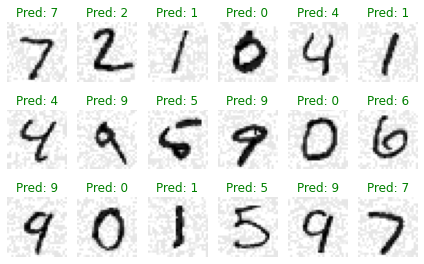

In [15]:
# Visualize test dataset samples accuracy that are perturbed by PGD attack and classified by trained cnn model
delta = pgd(model_cnn_robust, X, y)
yp = model_cnn_robust(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [16]:
print("PGD, 40 iter: ", adversarial_epoch(test_loader, model_cnn_robust, pgd, num_iter=40))

PGD, 40 iter:  0.0312
